<a href="https://colab.research.google.com/github/OlegLaiok/Comp_Lingv/blob/homework9/%D0%9B%D0%B0%D0%B19_%D0%B8%D1%81%D0%BF%D1%80%D0%B0%D0%B2%D0%BB%D0%B5%D0%BD%D0%BE_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install natasha

In [ ]:
import natasha
import json
import re
import pandas as pd
from natasha import Doc, Segmenter, NewsNERTagger, NewsEmbedding, NewsMorphTagger, MorphVocab
import pymorphy2 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.cluster import KMeans
analyzer = pymorphy2.MorphAnalyzer()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/VK_data_lentach_cleared.json", "r", encoding ='utf-8') as f:
    text = json.load(f)

Для выделения имменованных сущностей будем использовать тот же корпус новостей.

In [ ]:
embedding = NewsEmbedding() 
segmenter = Segmenter() # сегментация текста
morph_tagger = NewsMorphTagger(embedding) #морфологический анализ для дальейшей лемматизации и выделения тэгов именованных сущностей
morph_vocab = MorphVocab() 
ner_tagger = NewsNERTagger(embedding) #тэггер имменованных сущностей
df = pd.DataFrame.from_dict({'text':text}) #создадим датафрейм, где будем хранить исходный текст, именнованные сущности и номера кластеров

In [ ]:
def get_ner(transcript):
  script = Doc(re.sub(r'\((.*?)\)', "", transcript))
  script.segment(segmenter)
  script.tag_morph(morph_tagger)
  for token in script.tokens:
    token.lemmatize(morph_vocab)
  script.tag_ner(ner_tagger)
  for span in script.spans:
    span.normalize(morph_vocab)
  named_ents = [(i.text, i.type, i.normal) for i in script.spans]
  normed_ents = []
  for word, tag, norm in named_ents:
    if len(word.split()) == 1 and tag == "LOC":
      for gram in range(len(analyzer.parse(word))):
        if "Geox" in analyzer.parse(word)[gram].tag:
          normed_ents.append((analyzer.parse(word)[gram].normal_form))
          break
        elif gram == len(analyzer.parse(word)) - 1:
          normed_ents.append((norm.lower().strip(".,!?;-")))
    else:
      normed_ents.append((norm.lower().strip(".,!?;-")))
  return sorted(normed_ents)

Следующая функция работает таким образом:
1. текст сегментируется на токены
2. на токены накладывается частеречная разметка
4. токены лемматизируются
5. выделяются именованные сущности
6. токены нормализуются
7. обрабатывается нормализация географических объектов, т.к. в процессе выяснилось, что natasha хуже их нормализует, чем pymorphy2.



In [ ]:
normed_ent = []
for item in text:
    normed_ent.append(get_ner(item)) # из текстовых данных выделяем именнованные сущность для каждого документа и записываем их в датафрейм
df['named_entities'] = normed_ent
has_ner = [i for i in df.index.values if df.named_entities[i]] #составляем список не пустых именнованных сущностей
print(len(has_ner), df.shape[0]) # количество записей без пустых сущностей и с пустыми
df_ner = df[df.index.isin(has_ner)] #создаем датафрейм где у каждого текстового документа обязательно есть не пустые имен. сущности
ner_voc = []
for row in df_ner.named_entities.tolist():
  ner_voc.extend(row) 
len(ner_voc), len(set(ner_voc)) #количество всех сущностей в документе и количество уникальных сущностей

780 894


(2855, 1151)

In [ ]:
vocab = sorted(set(ner_voc)) #создаем словарь сущностей
corpus = df_ner.named_entities.apply(str).tolist() #создаем корпус всех сущностей
pipe = Pipeline([('count', CountVectorizer(vocabulary=vocab)),
                 ('tfid', TfidfTransformer())]).fit(corpus) #создаем конвеер преобразований
X = pipe.fit_transform(corpus) #применяем конвеер к корпусу

Для нахождения оптимального количесва кластеров будем ориентироваться на метрики Силует и Индекс Девиса-Болдуина. Для хорошего разбиения нам нужно, чтобы силуэт стремился к 1 а индекс Девиса-Болдуина был минимальным. Посмотрим как с изменением количесвтва кластеров будут меняться данные метрики:

In [ ]:
sil = {'sils':[],'klusters': range(5,50) }
ind = {'ind':[],'klusters': range(5,50) }
for i in range(5,50):
  km = KMeans(n_clusters=i, init='k-means++', max_iter=600, 
            algorithm="full", precompute_distances=True)
  km.fit(X)
  sil['sils'].append(metrics.silhouette_score(X, km.labels_, sample_size=1000))
  ind['ind'].append(metrics.davies_bouldin_score(X.toarray(), km.labels_))

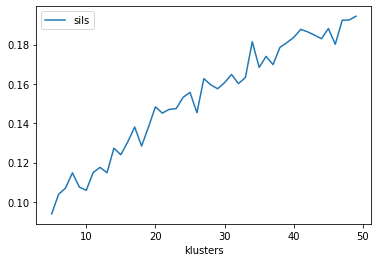

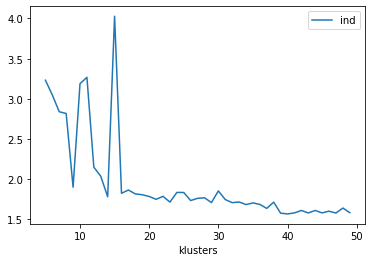

In [ ]:
df = pd.DataFrame.from_dict(sil)
df.plot(x='klusters',y='sils')
df1 = pd.DataFrame.from_dict(ind)
df1.plot(x='klusters',y='ind')

Видим, что с увеличением числа кластеров метрики улучаются, однако у нас слишком маленький объем данных, чтобы брать например 100 или 200 клсатеров, т.к. при таком увеличении числа кластеров будет слишком много кластеров где будет находится только один документ. Поэтому, исходя из данных графиков возьмем число кластеров равное 40, т.к силует на этом значении возрастает, а индекс Девиса-Болдуина будет близок к минимуму.

In [ ]:
  km = KMeans(n_clusters=40, init='k-means++', max_iter=600, 
            algorithm="full", precompute_distances=True)
  km.fit(X)
  print(metrics.silhouette_score(X, km.labels_, sample_size=1000))
  print(metrics.davies_bouldin_score(X.toarray(), km.labels_))

0.17720968107495208
1.658353515319428


In [ ]:
df_ner["label"] = km.predict(X)
print(df_ner["label"].value_counts()) #посмотрим сколько объектов пинадлежит каждому классу

6     453
1      45
5      27
11     25
19     20
25     17
9      17
37     15
26     13
23     12
28     10
14     10
18      9
7       9
36      8
38      7
21      7
20      6
24      5
12      5
29      5
8       5
10      4
4       4
39      4
22      4
34      4
16      3
17      3
27      3
32      3
35      3
0       3
15      2
13      2
30      2
31      2
2       2
33      1
3       1
Name: label, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Заметим, что большое количесво объектов сгрупперовалось в шестом кластере, скорее всего там находятся данные, которые алгоритм не смог определить в другие классы. Посмотрим примеры сущностей, содержащихся в этих статьях

In [ ]:
df_ner.query("label == 6").sample(10)

,text,named_entities,label
358,— Но ты не должна меня ждать. Никогда. Очень с...,"[the washington post, бразилия, воз, иль-де-фр...",6
473,В Подмосковье врачи спасли двухгодовалого ребё...,[подмосковье],6
673,В Магадане водитель маршрутки высадил 13-летне...,[магадан],6
447,В Татарстане дети выстроились на коленях в сне...,"[вишневка, минниханов, привольный, рустам минн...",6
826,Глава Следственного комитета Бастрыкин призвал...,"[бастрыкин, следственный комитет]",6
70,Человечество может остаться без бананов из-за ...,[die welt],6
644,"Крым получит 2,2 млрд рублей на поиск месторо...","[крым, россия, слуга народ, тимошенко, школа к...",6
15,ЦБ отозвал лицензию у екатеринбургского банка...,"[nasa, мкс, нейва, тбилиси, цб]",6
63,Хочешь рассмешить бога — расскажи ему о своих ...,"[scmp, аргентина, китай, ковивак, минздрав, но...",6
275,"Все суда, которые застряли из-за контейнеровоз...","[помянем, суэцкий канал]",6


Видим, что тут содержатся документы имеющие нетипичные темы, поэтому кластеризация для них прошла не совсем корректно.
Выведем получившиеся кластеры имменованных сущностей:

In [ ]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = pipe[0].get_feature_names()
for i in range(40):
  print("Cluster %d:" % i, end='')
  for ind in order_centroids[i, :10]:
    print(' %s' % terms[ind], end='')
  print()

Cluster 0: манижи ск совфед матвиенко россия дмитрий глуховского диана дзюба джордж флойд джон магуфули
Cluster 1: петербург москва россия ярославль джастин трюдо джеймс кэмерон джек дорси джефф безос джимми хендрикс джо байден
Cluster 2: бразилия нтв госдума дмитрий песков дмитрий лисовец дмитрий ионин дмитрий глуховского диана дзюба детская студия «дом свет
Cluster 3: магуфули танзания рф киргизия рпц австрия греция ес япония дзюба
Cluster 4: китай воз сми джон магуфули джастин трюдо джеймс кэмерон джек дорси джефф безос джимми хендрикс джо байден
Cluster 5: россия сша aliexpress узбекистан фсб рф воз путин стокгольм госдепартамент
Cluster 6: россия astrazeneca германия воз франция крым вконтакте сша великобритания facebook
Cluster 7: байден сша россия вашингтон сводочку китай афганистан роскомнадзор голливуд украина
Cluster 8: петербург ярославль день пэйнта джастин трюдо джеймс кэмерон джек дорси джефф безос джимми хендрикс джо байден джон магуфули
Cluster 9: госдума россия реж изв

Не смотря на то, что кластеризация получилась не идеальная, в каждом кластере прослеживаются какие-то ключевые темы. Например какие-то кластеры будут содержать сущности из новостей про знаменитостей (кластер 0), туризм(кластер 18), IT (кластер 25) и тд.
Однако, число именованных сущностей для моих данных небольшое (2855 всего и 1151 уникальных), поэтому можно сделать вывод, что для моих данных лучше использовать другой тип кластеризации, например LDA, чтобы получить более точное разбиение.